In [1]:
!nvidia-smi

Sun Dec  4 10:27:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# importing libraries
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection  import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

from keras_tuner.tuners import RandomSearch
%matplotlib inline 

In [5]:
os.listdir()

['.config', 'Churn_Modelling.csv', 'sample_data']

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
df = pd.read_csv('Churn_Modelling.csv')
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [8]:
df = df.drop(columns = ['RowNumber','CustomerId','Surname'])
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [9]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [10]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [11]:
df['Gender'].value_counts()

Male      5457
Female    4543
Name: Gender, dtype: int64

In [12]:
# one hot encoding 
geography_ohe = pd.get_dummies(df.Geography, prefix = 'Geography')
gender_ohe = pd.get_dummies(df.Gender, prefix = 'Gender')

display(geography_ohe)
display(gender_ohe)

,Geography_France,Geography_Germany,Geography_Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,0,1,0


,Gender_Female,Gender_Male
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
9995,0,1
9996,0,1
9997,1,0
9998,0,1


In [13]:
data = pd.concat([df,geography_ohe,gender_ohe ], axis = 'columns').drop(columns = ['Geography','Gender'])
data.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_France   10000 non-null  uint8  
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
 12  Gender_Female      10000 non-null  uint8  
 13  Gender_Male        10000 non-null  uint8  
dtypes: float64(2), int64(7), uint8(5)
memory usage: 752.1 KB


In [15]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700,0.501400,0.250900,0.247700,0.454300,0.545700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769,0.500023,0.433553,0.431698,0.497932,0.497932
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
# splitting the data
train, test = train_test_split(data, test_size = 0.2, random_state = 64)
train.shape, test.shape

((8000, 14), (2000, 14))

In [17]:
# Normalizing the data 
normalizer_tr, normalize_ts = MinMaxScaler(), MinMaxScaler()

train_scaled = pd.DataFrame(normalizer_tr.fit_transform(train), columns = train.columns)
test_scaled = pd.DataFrame(normalize_ts.fit_transform(test), columns = test.columns)

display(train_scaled)
display(test_scaled)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.442,0.391892,0.7,0.000000,0.333333,0.0,0.0,0.561831,0.0,1.0,0.0,0.0,1.0,0.0
1,0.358,0.216216,0.9,0.000000,0.000000,1.0,1.0,0.466028,0.0,0.0,0.0,1.0,0.0,1.0
2,0.612,0.364865,0.7,0.581644,0.000000,1.0,1.0,0.996998,0.0,1.0,0.0,0.0,1.0,0.0
3,0.854,0.148649,0.9,0.523083,0.000000,1.0,1.0,0.818751,1.0,1.0,0.0,0.0,1.0,0.0
4,0.848,0.243243,0.9,0.521366,0.000000,1.0,0.0,0.761466,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.502,0.324324,0.1,0.392573,0.000000,1.0,0.0,0.200035,1.0,0.0,1.0,0.0,0.0,1.0
7996,0.650,0.486486,0.6,0.000000,0.000000,1.0,0.0,0.551364,1.0,1.0,0.0,0.0,0.0,1.0
7997,0.190,0.256757,0.3,0.000000,0.333333,1.0,1.0,0.900090,0.0,1.0,0.0,0.0,0.0,1.0
7998,0.520,0.256757,0.0,0.000000,0.000000,1.0,0.0,0.572570,0.0,1.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.474,0.587302,0.9,0.000000,0.000000,1.0,0.0,0.322775,0.0,1.0,0.0,0.0,0.0,1.0
1,0.670,0.396825,0.9,0.000000,0.333333,1.0,0.0,0.539040,0.0,0.0,0.0,1.0,0.0,1.0
2,0.884,0.015873,0.7,0.673897,0.000000,1.0,0.0,0.166097,0.0,1.0,0.0,0.0,0.0,1.0
3,0.858,0.349206,0.2,0.354690,0.000000,1.0,1.0,0.264232,0.0,0.0,1.0,0.0,1.0,0.0
4,0.994,0.761905,0.7,0.581642,0.000000,0.0,1.0,0.265549,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.820,0.301587,0.7,0.000000,0.000000,0.0,0.0,0.163998,1.0,1.0,0.0,0.0,0.0,1.0
1996,0.730,0.428571,0.4,0.000000,0.333333,1.0,1.0,0.274991,0.0,1.0,0.0,0.0,0.0,1.0
1997,0.654,0.396825,0.3,0.626074,0.333333,1.0,1.0,0.479620,0.0,0.0,0.0,1.0,1.0,0.0
1998,0.848,0.285714,0.8,0.550584,0.000000,0.0,0.0,0.509101,0.0,0.0,0.0,1.0,1.0,0.0


In [18]:
target = 'Exited'

x_tr, y_tr = train_scaled.drop(columns = [target]), train_scaled[[target]]
x_ts, y_ts = test_scaled.drop(columns = [target]), test_scaled[[target]]

x_tr.shape, y_tr.shape, x_ts.shape, y_ts.shape 

((8000, 13), (8000, 1), (2000, 13), (2000, 1))

#Building the Neural Network

In [35]:
#____________Generating the basic structure of ANN _____________
# instance of model
model = tf.keras.Sequential()

## Adding the input layer 
model.add(tf.keras.layers.Input(shape = (13,)))

# Adding the hidden layers
# Hidden layer I
model.add(tf.keras.layers.Dense(units = 6, activation = 'relu',kernel_initializer = 'he_normal'))

# Hidden layer II
model.add(tf.keras.layers.Dense(units = 8, activation = 'relu', kernel_initializer = 'he_normal'))

# Adding the out put layer
model.add(tf.keras.layers.Dense(units = 1, activation = 'sigmoid', kernel_initializer= 'glorot_normal'))

#__________Compilining the model_________________________
model.compile(optimizer = 'Adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy','Precision','Recall'])



In [36]:
# summarizing the model 
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 6)                 84        
                                                                 
 dense_14 (Dense)            (None, 8)                 56        
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 149
Trainable params: 149
Non-trainable params: 0
_________________________________________________________________


In [37]:
from traitlets.traitlets import validate
# Trainig the Model 
history_object = model.fit(x = x_tr,
                           y = y_tr,
                           batch_size = 512,
                           epochs = 100,
                           validation_data = (x_ts, y_ts),
                           validation_batch_size = 512,
                           use_multiprocessing = True,
                           workers = 20)

Epoch 1/100
16/16 [==============================] - 1s 30ms/step - loss: 0.5246 - accuracy: 0.7924 - precision: 0.1923 - recall: 0.0030 - val_loss: 0.5102 - val_accuracy: 0.8035 - val_precision: 0.4000 - val_recall: 0.0051
Epoch 2/100
16/16 [==============================] - 0s 7ms/step - loss: 0.5117 - accuracy: 0.7940 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.5004 - val_accuracy: 0.8035 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.5046 - accuracy: 0.7944 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4939 - val_accuracy: 0.8040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 0.4995 - accuracy: 0.7944 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.4880 - val_accuracy: 0.8040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/100
16/16 [==============================] - 0s 6ms

In [38]:
type(history_object)

keras.callbacks.History

In [39]:
dir(history_object)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_chief_worker_only',
 '_implements_predict_batch_hooks',
 '_implements_test_batch_hooks',
 '_implements_train_batch_hooks',
 '_keras_api_names',
 '_keras_api_names_v1',
 '_supports_tf_logs',
 'epoch',
 'history',
 'model',
 'on_batch_begin',
 'on_batch_end',
 'on_epoch_begin',
 'on_epoch_end',
 'on_predict_batch_begin',
 'on_predict_batch_end',
 'on_predict_begin',
 'on_predict_end',
 'on_test_batch_begin',
 'on_test_batch_end',
 'on_test_begin',
 'on_test_end',
 'on_train_batch_begin',
 'on_train_batch_end',
 'on_train_begin',
 'on_train_end',
 'params',
 'set_model',
 'set_params',
 'validation_data']

In [40]:
hist = history_object.history
epoch = history_object.epoch

In [41]:
# fetching the required data from history object

def visualizer(history_obj, parameter):
  plt.figure(figsize = (24,10))
  train_param = history_obj.history.get(parameter)
  val_param = history_obj.history.get(f'val_{parameter}')
  epochs = history_obj.epoch

  sns.lineplot(x = epochs, y = train_param)
  sns.lineplot(x = epochs, y = val_param)

  plt.legend(labels = [parameter, f'val_{parameter}'])
  plt.xticks(ticks = epoch, labels = epoch, rotation = 90)
  plt.yticks(ticks = [i/100 for i in range(10,110,10)],labels = [i/100 for i in range(10,110,10)])
  plt.show()

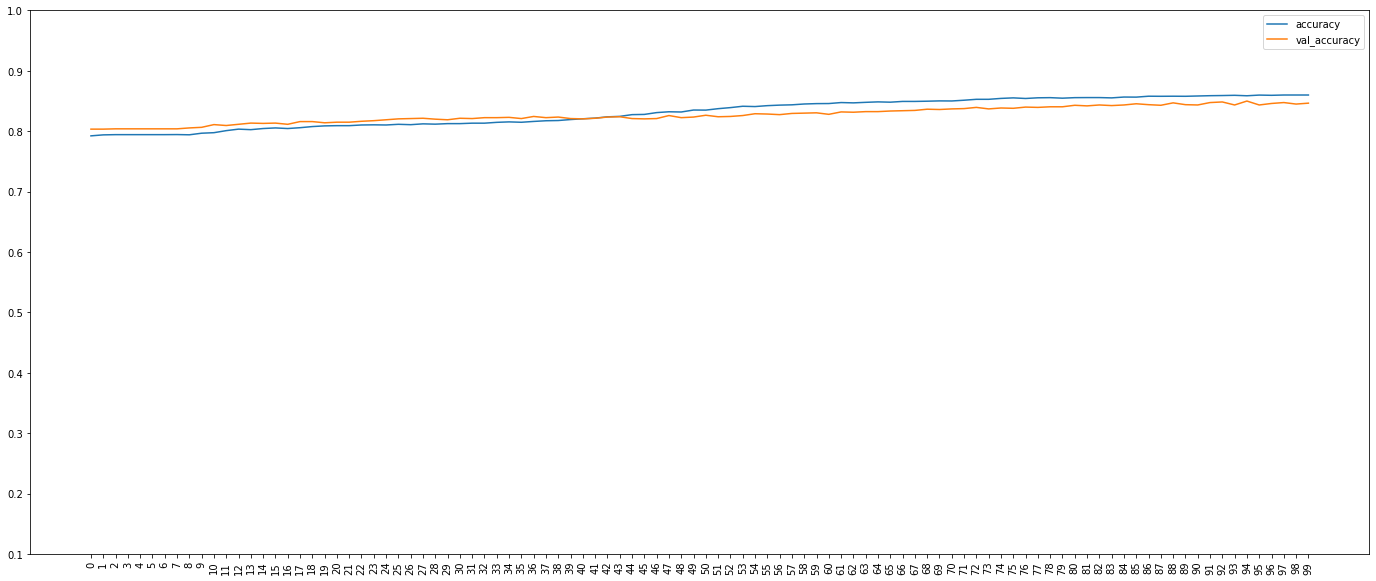

In [42]:
visualizer(history_object,'accuracy')

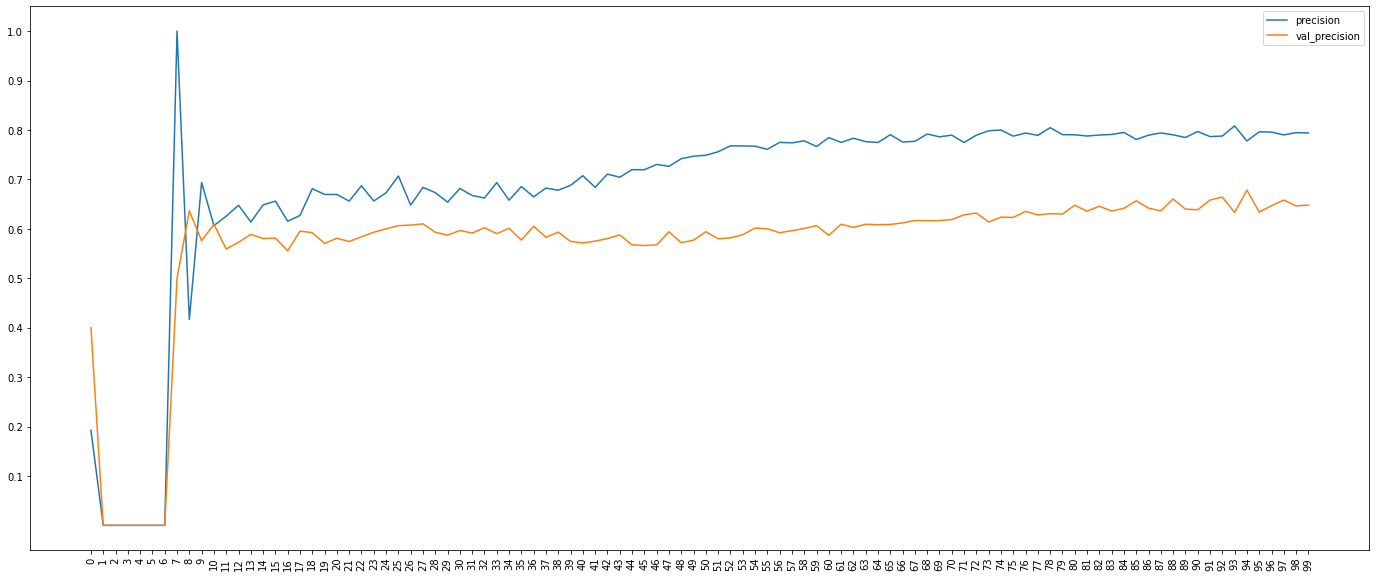

In [43]:
visualizer(history_object, 'precision')

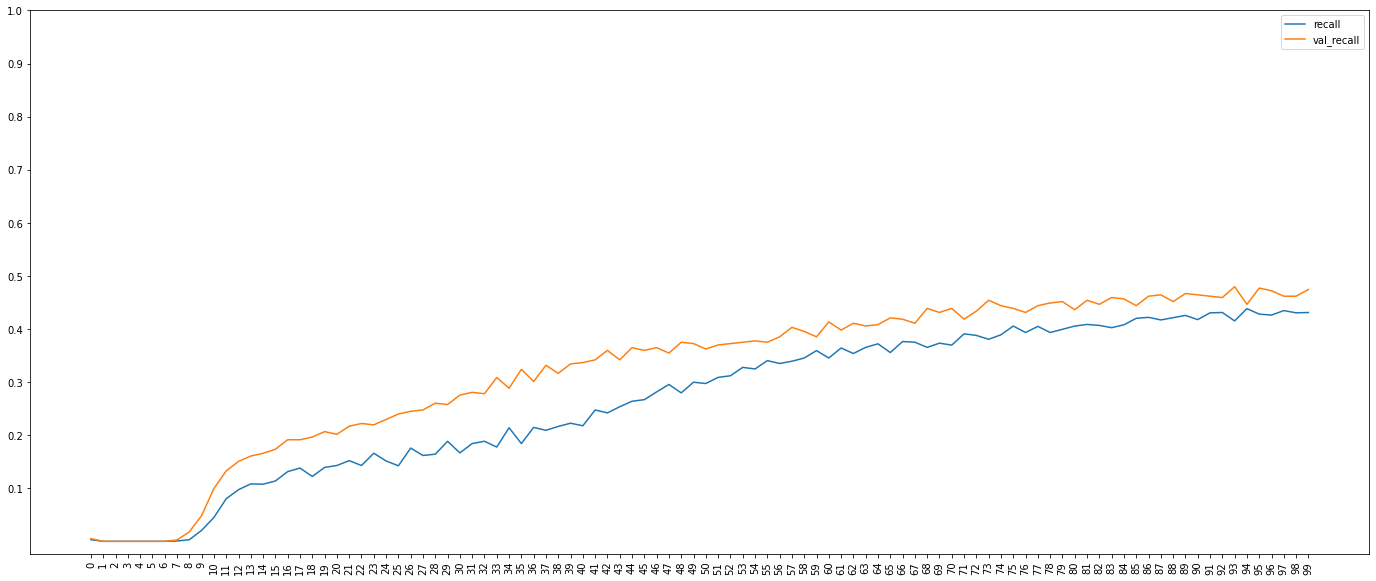

In [44]:
visualizer(history_object, 'recall')

In [45]:
# Early Stopping 

early_stopper = EarlyStopping(monitor = 'accuracy', patience = 10 )

In [46]:
history_object = model.fit(x = x_tr,
                           y = y_tr,
                           batch_size = 512,
                           epochs = 100,
                           validation_data = (x_ts, y_ts),
                           validation_batch_size = 512,
                           use_multiprocessing = True,
                           workers = 20,
                           callbacks = [early_stopper])

Epoch 1/100
16/16 [==============================] - 0s 9ms/step - loss: 0.3520 - accuracy: 0.8600 - precision: 0.7933 - recall: 0.4316 - val_loss: 0.3585 - val_accuracy: 0.8465 - val_precision: 0.6523 - val_recall: 0.4643
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3518 - accuracy: 0.8600 - precision: 0.7832 - recall: 0.4413 - val_loss: 0.3570 - val_accuracy: 0.8470 - val_precision: 0.6558 - val_recall: 0.4617
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3516 - accuracy: 0.8599 - precision: 0.7931 - recall: 0.4310 - val_loss: 0.3571 - val_accuracy: 0.8475 - val_precision: 0.6582 - val_recall: 0.4617
Epoch 4/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3513 - accuracy: 0.8604 - precision: 0.7920 - recall: 0.4353 - val_loss: 0.3595 - val_accuracy: 0.8455 - val_precision: 0.6456 - val_recall: 0.4694
Epoch 5/100
16/16 [==============================] - 0s 6ms/step - loss: 0.3510 - accuracy: 0.8611 - precisi